## Analisis Anomali Detection Motor XX

### 1. Data Loading

In [87]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [88]:
# Loading Data
df = pd.read_csv("yaskawa_train.csv")

# Konversi waktu ke dalam format waktu seconds
df['Time'] = pd.to_timedelta(df['Time'])
df['Time'] = df['Time'].dt.total_seconds()
df.sort_index()

df.tail(100)

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh)
2303,1147.973,48.07,48.08,80.73,45.1,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2304,1148.564,48.08,48.08,84.30,45.1,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2305,1149.141,48.07,48.07,82.27,40.5,370.3,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2306,1149.736,48.08,48.08,81.52,45.0,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2307,1150.331,48.08,48.08,83.02,43.3,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,1204.510,48.08,48.08,82.45,39.1,370.3,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2399,1205.245,48.08,48.08,80.60,43.6,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2400,1205.950,48.08,48.08,84.52,44.2,370.6,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2401,1206.561,48.08,48.08,80.20,45.1,370.3,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0


In [89]:
# Kolom baru
df['RPM Ref'] = df['Frequency Reference'] * 120 / 2
df['RPM Out'] = df['Output Frequency'] * 120 / 2
df['Power Factor'] = (df['Output Power'] * 1000) / (np.sqrt(3) * df['Output Voltage'] * df['Output Current'])
df['Slip (%)'] = (abs(df['RPM Out'] - df['RPM Ref']) / df['RPM Out']) * 100
df['Daya Semu (kVA)'] = (np.sqrt(3) * df['Output Voltage'] * df['Output Current']) / 1000
df['Efficiency (%)'] = 93.5
df['Daya Output Motor (kW)'] = (np.sqrt(3) * df['Output Voltage'] * df['Output Current'] * df['Efficiency (%)'] / 100 * df['Power Factor']) / 1000
df['Torque (Nm)'] = 5250*746*1.356/df['RPM Out']
df.head(100)

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
0,0.182,48.08,48.08,84.12,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841023,0.000000,53.981892,93.5,42.4490,1840.950499
1,0.323,48.09,48.08,82.67,44.3,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2885.4,2884.8,0.835039,0.020799,53.051391,93.5,41.4205,1840.950499
2,0.464,48.08,48.08,84.08,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841423,0.000000,53.956223,93.5,42.4490,1840.950499
3,0.612,48.08,48.08,86.50,45.1,370.6,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.812259,0.000000,55.524180,93.5,42.1685,1840.950499
4,0.756,48.08,48.08,80.95,44.5,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.856632,0.000000,51.947625,93.5,41.6075,1840.950499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15.936,48.07,48.08,82.49,40.5,370.3,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.2,2884.8,0.765490,0.020799,52.907305,93.5,37.8675,1840.950499
96,16.124,48.08,48.08,80.51,43.3,370.3,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.838540,0.000000,51.637376,93.5,40.4855,1840.950499
97,16.317,48.08,48.08,80.38,45.0,370.4,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.872636,0.000000,51.567919,93.5,42.0750,1840.950499
98,16.502,48.08,48.08,80.82,45.1,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.869579,0.000000,51.864200,93.5,42.1685,1840.950499


In [90]:
# Cek apakah ada duplikasi
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

# Hapus data duplikat
df = df.drop_duplicates()

Jumlah data duplikat: 0


In [91]:
# Cek apakah ada data kosong
print(f"Jumlah data kosong: {df.isnull().sum()}")

Jumlah data kosong: Time                                 0
Frequency Reference                  0
Output Frequency                     0
Output Current                       0
Output Power                         0
Output Voltage                       0
Minor Fault                          0
Major Fault                          0
During Run                           0
Fault Output                         0
Output Frequency After Soft-start    0
Over Run Error                       0
Timeout                              0
Fin Temperature                      0
Cooling Fin Temperature              0
Cooling Fan Operation Time           0
Electric Power (kWh)                 0
RPM Ref                              0
RPM Out                              0
Power Factor                         0
Slip (%)                             0
Daya Semu (kVA)                      0
Efficiency (%)                       0
Daya Output Motor (kW)               0
Torque (Nm)                          0
dtype

In [92]:
baris_kosong = df[df.isnull().any(axis=1)]

baris_kosong

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)


In [93]:
train = df.dropna()
train

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
0,0.182,48.08,48.08,84.12,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841023,0.000000,53.981892,93.5,42.4490,1840.950499
1,0.323,48.09,48.08,82.67,44.3,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2885.4,2884.8,0.835039,0.020799,53.051391,93.5,41.4205,1840.950499
2,0.464,48.08,48.08,84.08,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841423,0.000000,53.956223,93.5,42.4490,1840.950499
3,0.612,48.08,48.08,86.50,45.1,370.6,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.812259,0.000000,55.524180,93.5,42.1685,1840.950499
4,0.756,48.08,48.08,80.95,44.5,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.856632,0.000000,51.947625,93.5,41.6075,1840.950499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,1204.510,48.08,48.08,82.45,39.1,370.3,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.739387,0.000000,52.881650,93.5,36.5585,1840.950499
2399,1205.245,48.08,48.08,80.60,43.6,370.5,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.842952,0.000000,51.723021,93.5,40.7660,1840.950499
2400,1205.950,48.08,48.08,84.52,44.2,370.6,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.814698,0.000000,54.253221,93.5,41.3270,1840.950499
2401,1206.561,48.08,48.08,80.20,45.1,370.3,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.876774,0.000000,51.438549,93.5,42.1685,1840.950499


In [94]:
train.describe()

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
count,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.0,2403.0,2403.0,2403.0,...,2403.0,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.0,2403.000000,2403.000000
mean,513.819447,48.079005,48.078960,82.627191,43.609155,370.421057,0.0,0.0,1.0,0.0,...,1388.0,642.024136,2884.740325,2884.737578,0.822810,0.003557,53.012797,93.5,40.774560,1840.990348
std,370.394953,0.005094,0.004071,1.927013,2.131757,0.082110,0.0,0.0,0.0,0.0,...,0.0,4.491207,0.305625,0.244231,0.039678,0.007833,1.243973,0.0,1.993193,0.155874
min,0.182000,48.060000,48.070000,79.010000,36.500000,370.200000,0.0,0.0,1.0,0.0,...,1388.0,636.000000,2883.600000,2884.200000,0.689886,0.000000,50.675308,93.5,34.127500,1840.567686
25%,168.730000,48.080000,48.080000,81.000000,42.500000,370.400000,0.0,0.0,1.0,0.0,...,1388.0,638.000000,2884.800000,2884.800000,0.804036,0.000000,51.951652,93.5,39.737500,1840.950499
50%,470.054000,48.080000,48.080000,82.450000,44.300000,370.400000,0.0,0.0,1.0,0.0,...,1388.0,642.000000,2884.800000,2884.800000,0.830042,0.000000,52.895931,93.5,41.420500,1840.950499
75%,835.915500,48.080000,48.080000,84.260000,45.100000,370.500000,0.0,0.0,1.0,0.0,...,1388.0,646.000000,2884.800000,2884.800000,0.850749,0.000000,54.057139,93.5,42.168500,1840.950499
max,1207.247000,48.090000,48.090000,86.860000,47.400000,370.600000,0.0,0.0,1.0,0.0,...,1388.0,650.000000,2885.400000,2885.400000,0.894492,0.020803,55.740218,93.5,44.319000,1841.333472


### 2. Exploratory Data Analysis

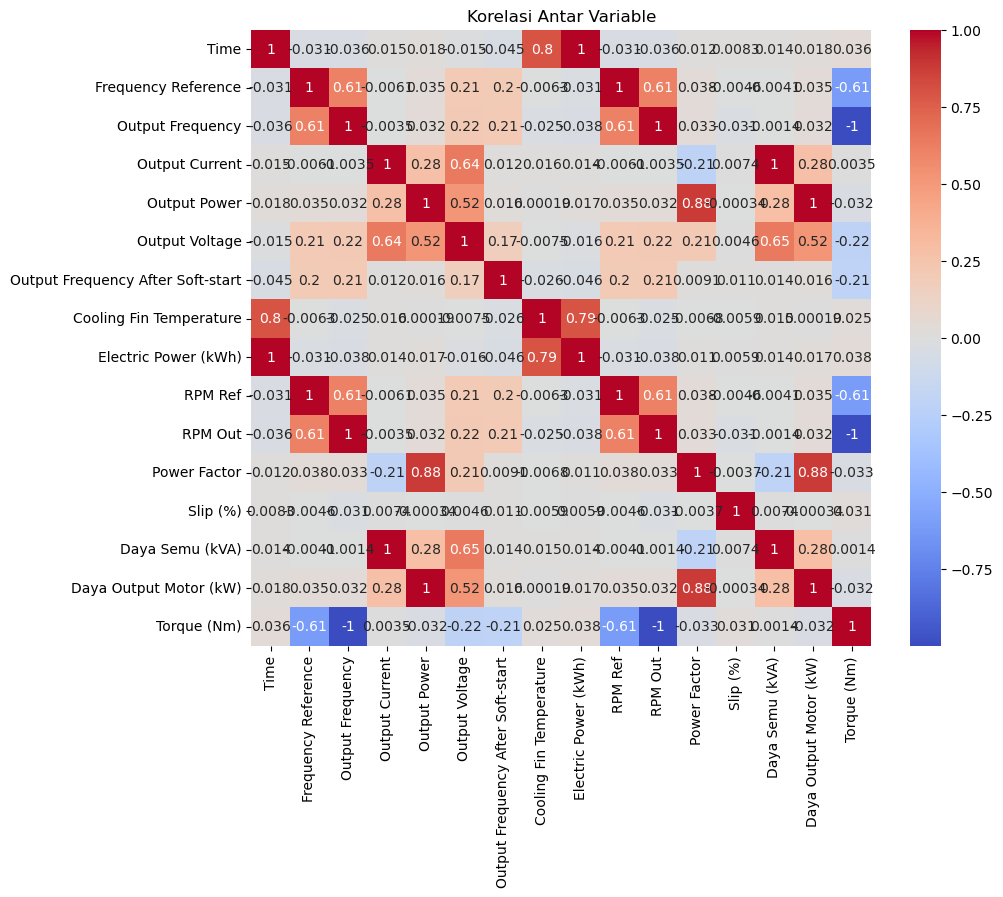

In [95]:
# Menghapus kolom yang memiliki nilai konstan dan yang hanya berisi 0 dan 1
filtered_cols = [col for col in train.columns
                 if train[col].nunique() > 1 and not set(train[col].unique()).issubset({0, 1})]

filtered_train = train[filtered_cols]

# Menghitung korelasi dan menampilkan heatmap
corr = filtered_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variable')
plt.show()

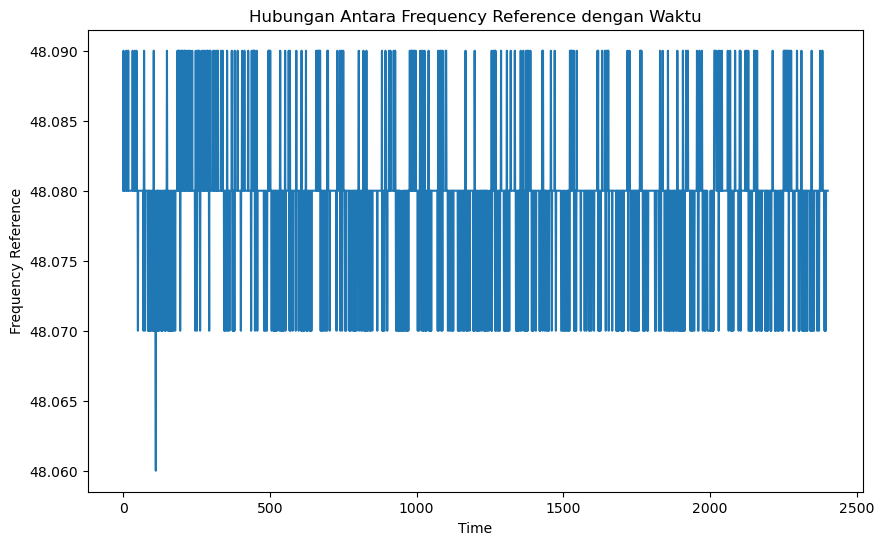

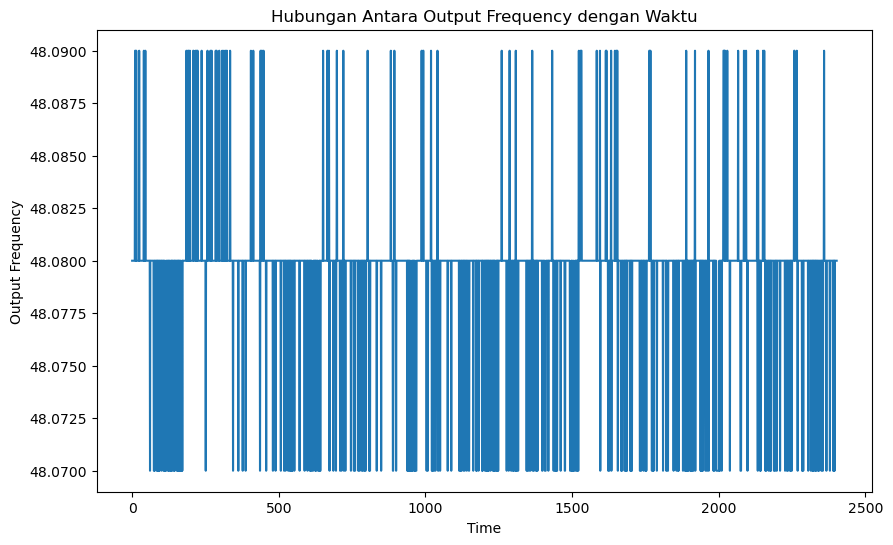

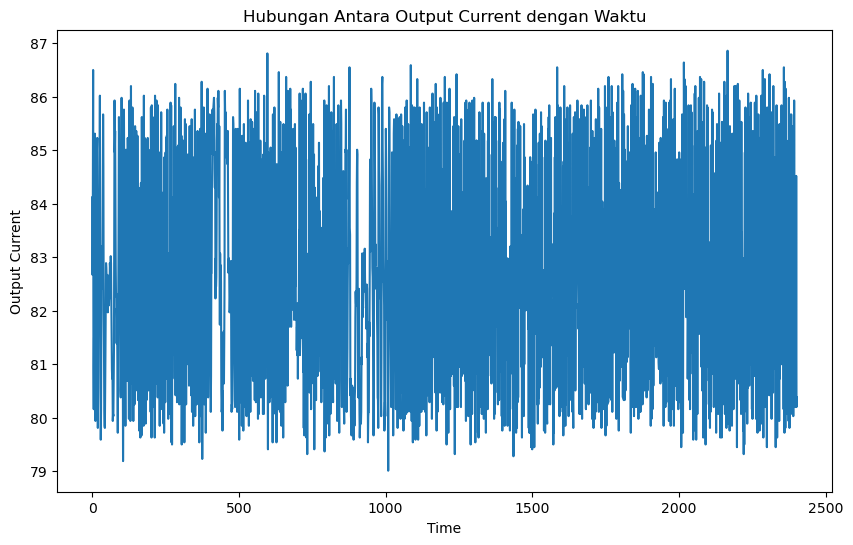

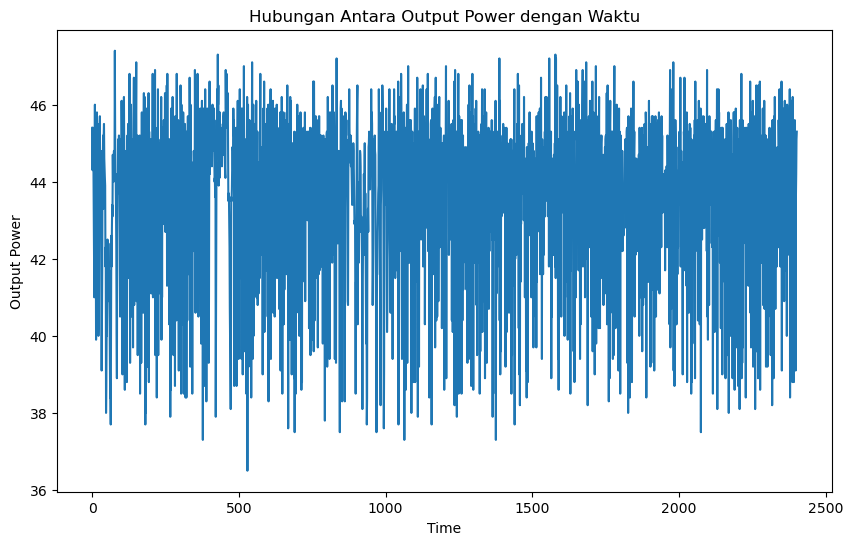

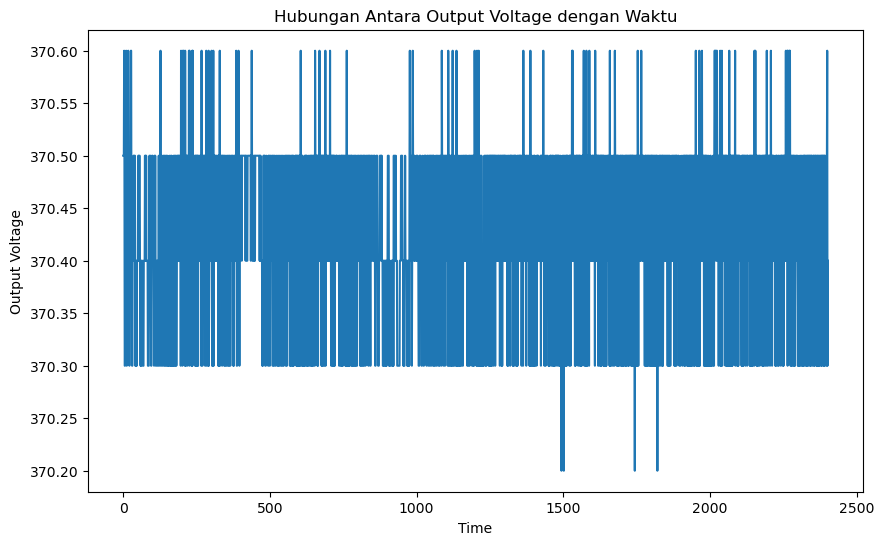

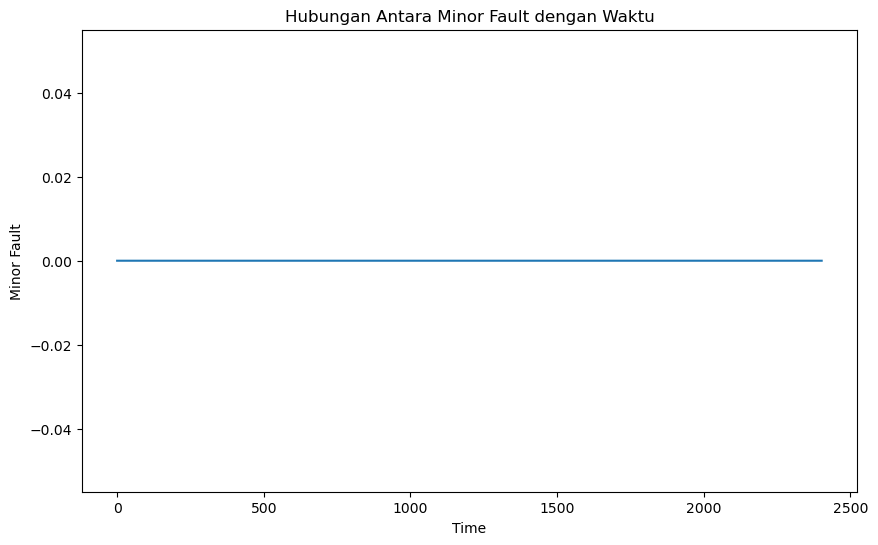

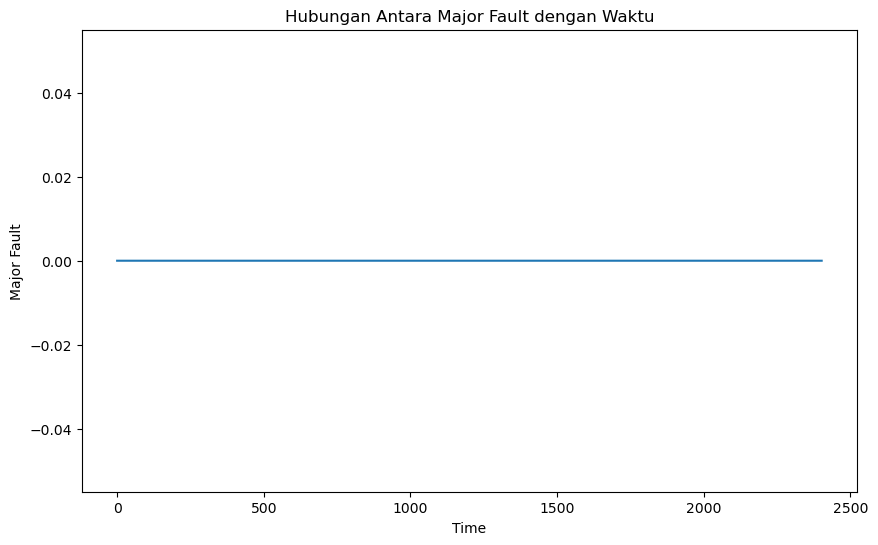

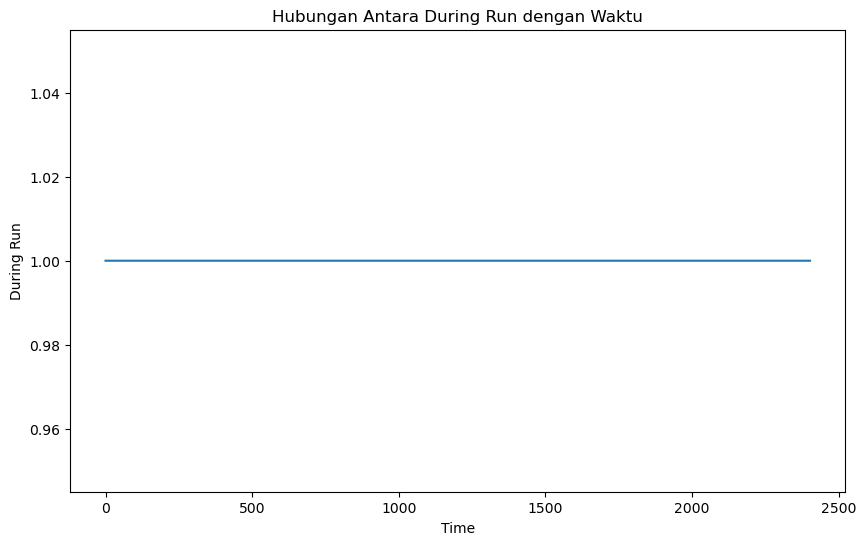

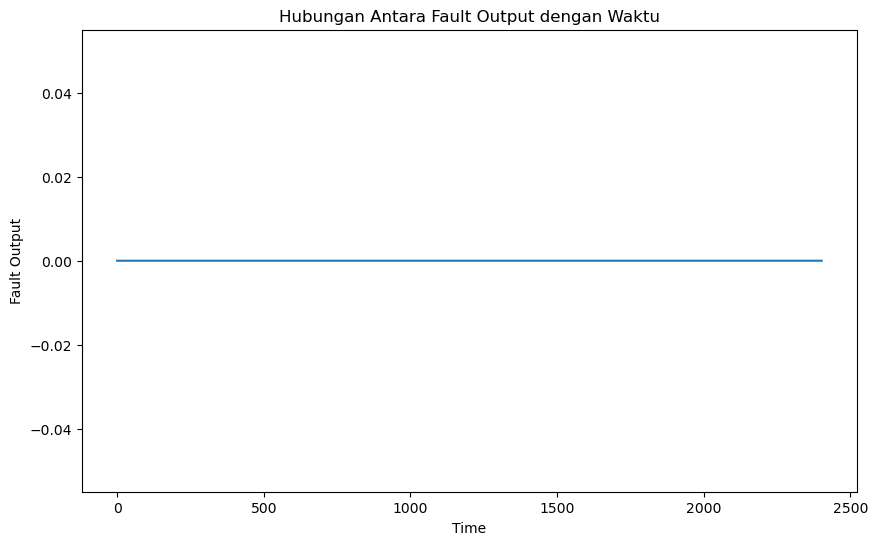

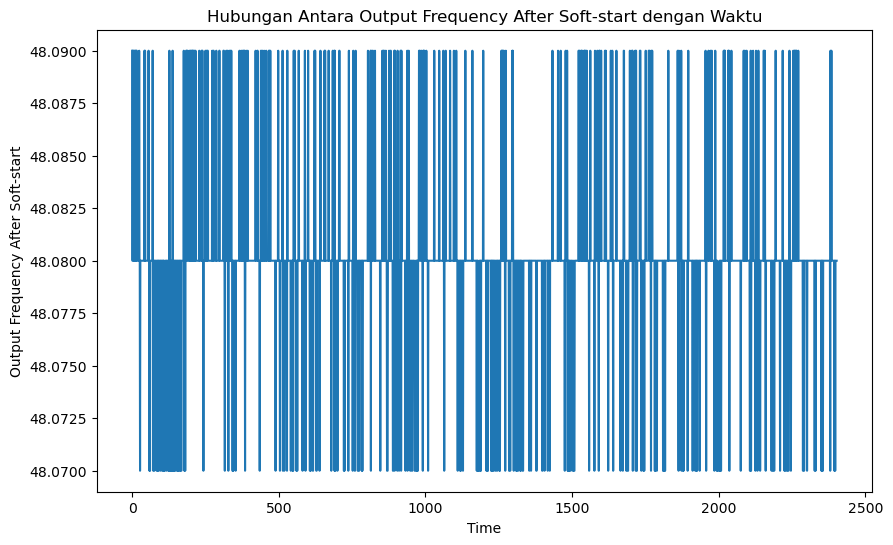

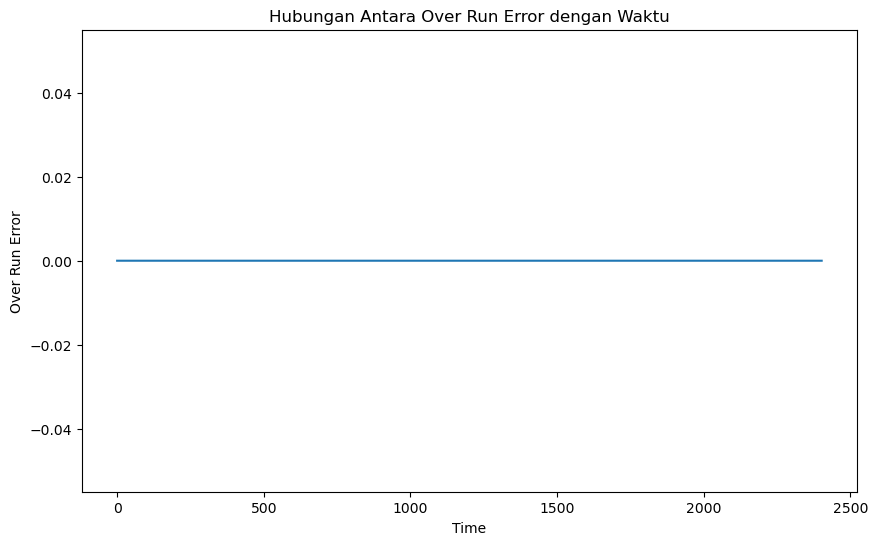

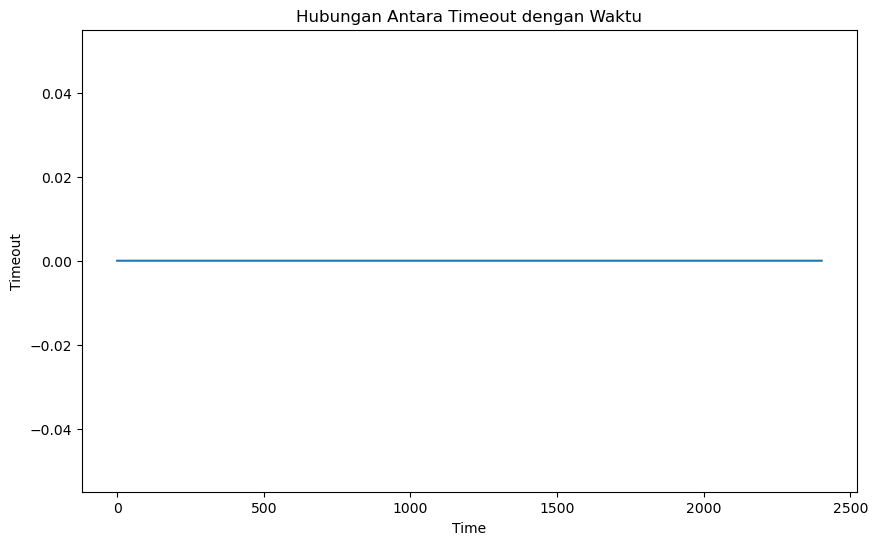

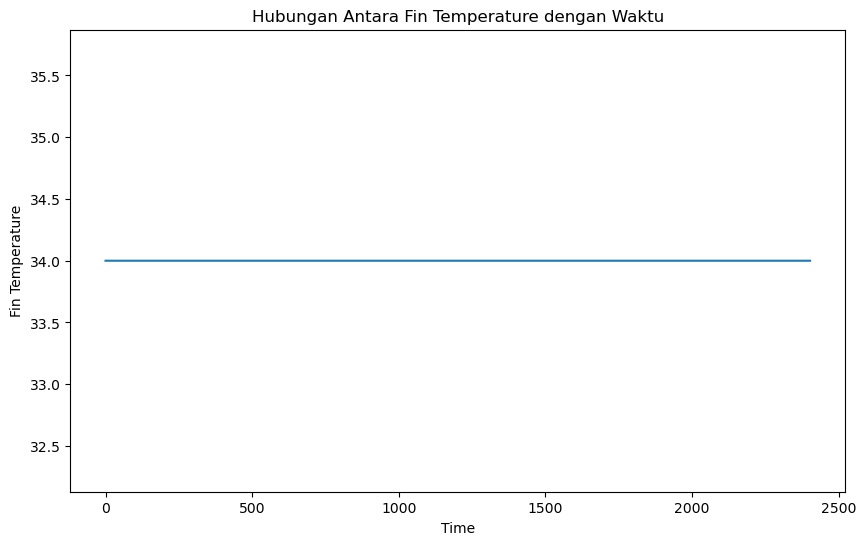

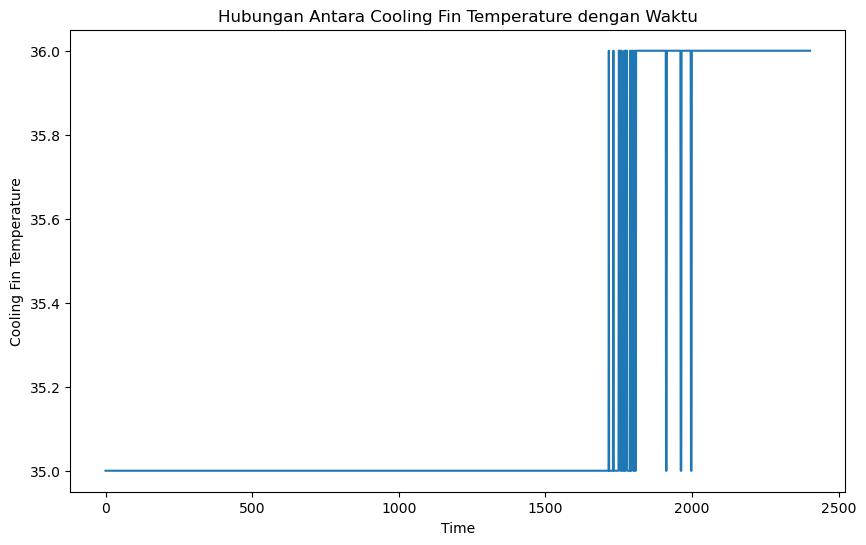

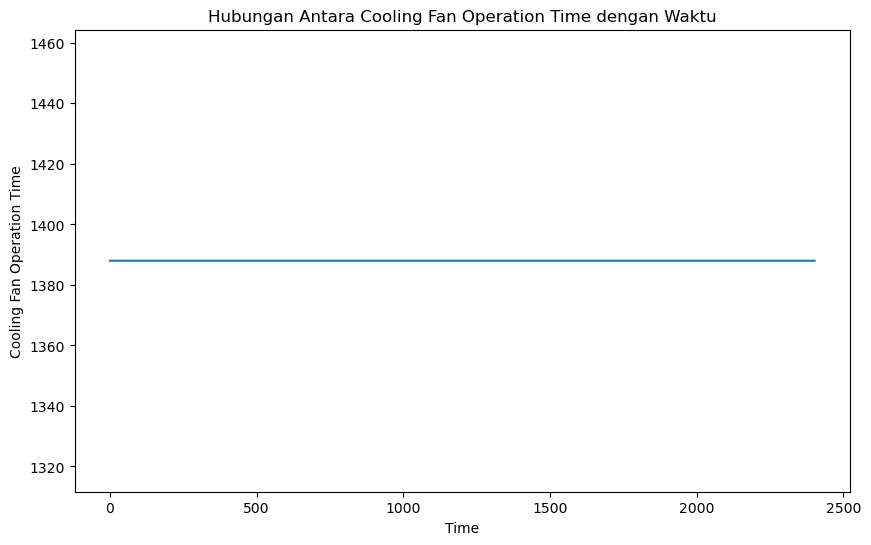

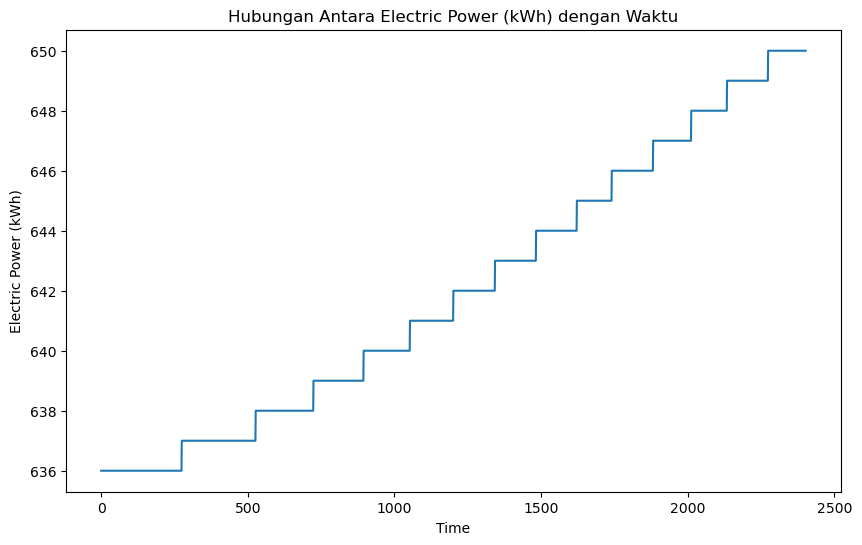

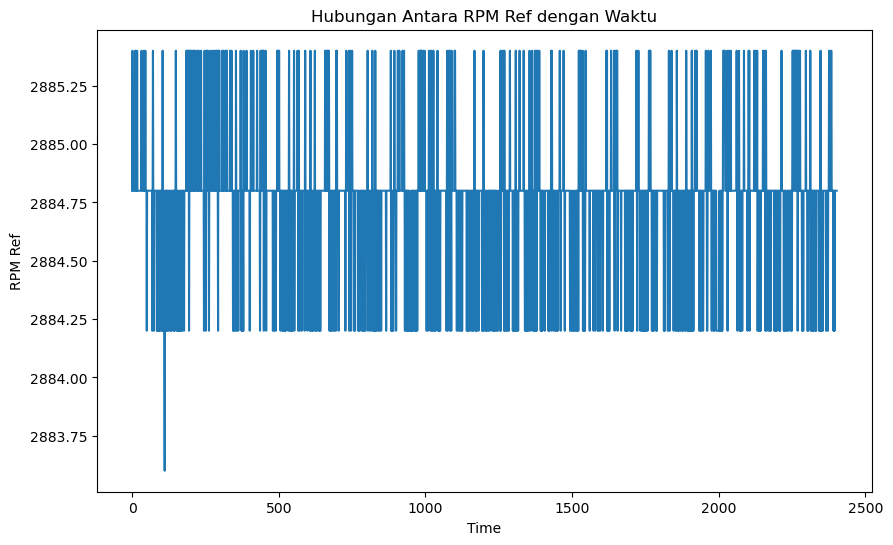

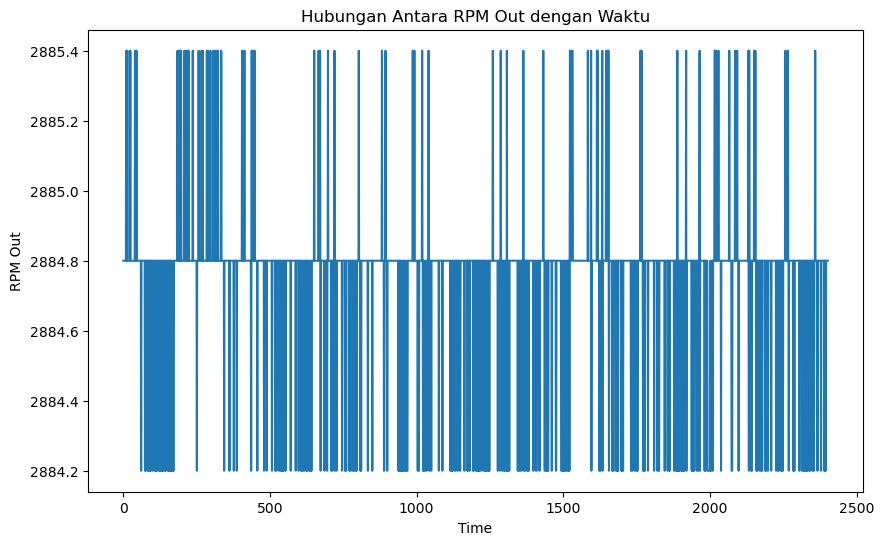

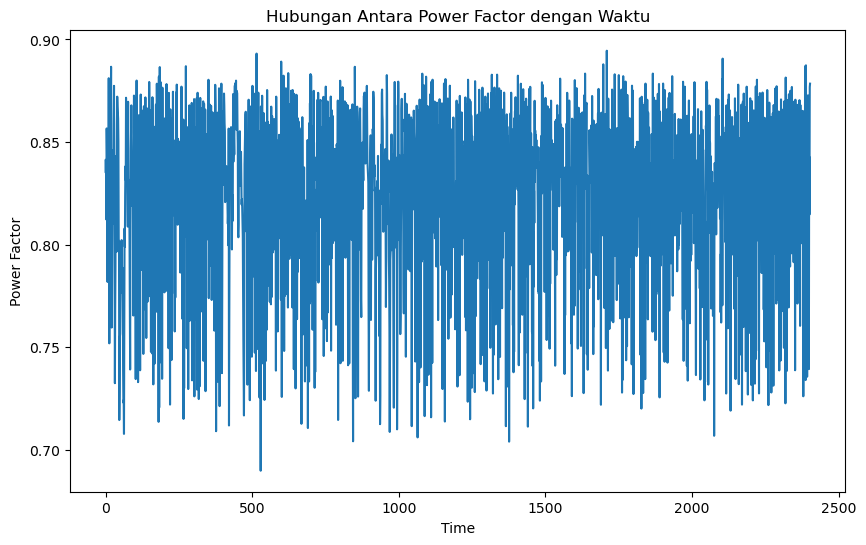

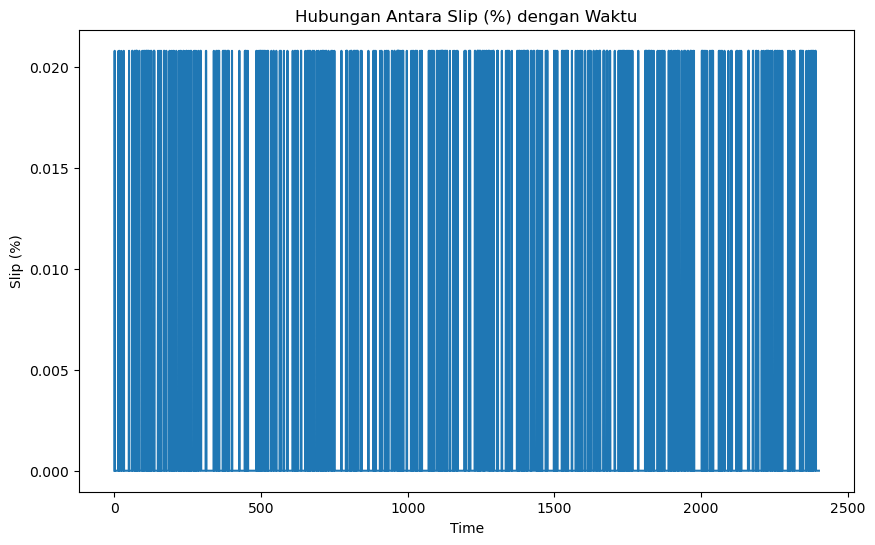

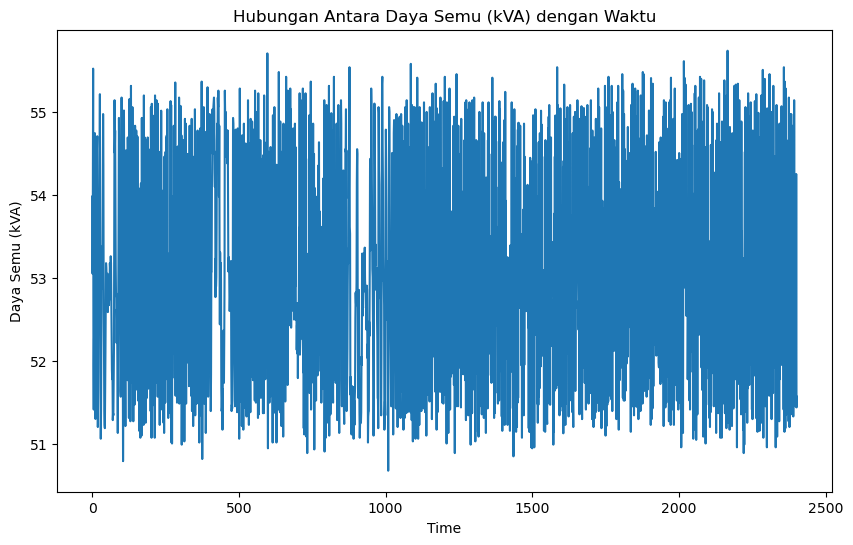

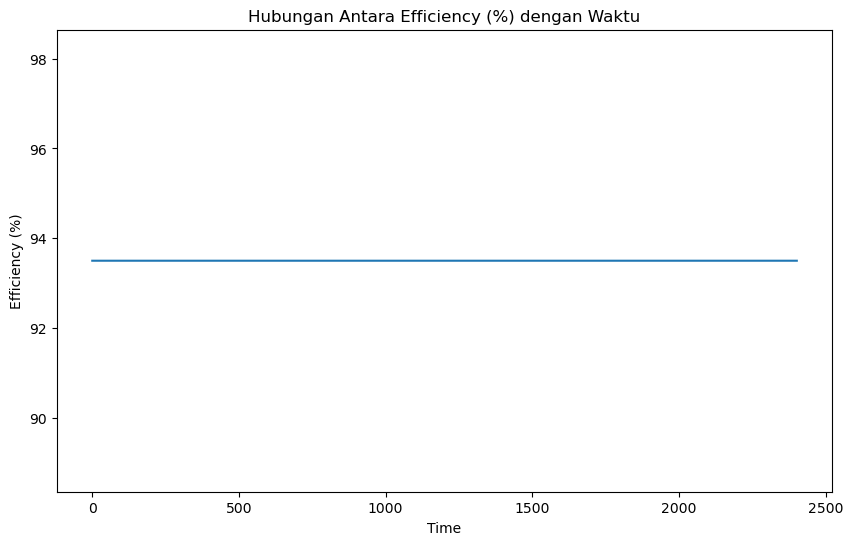

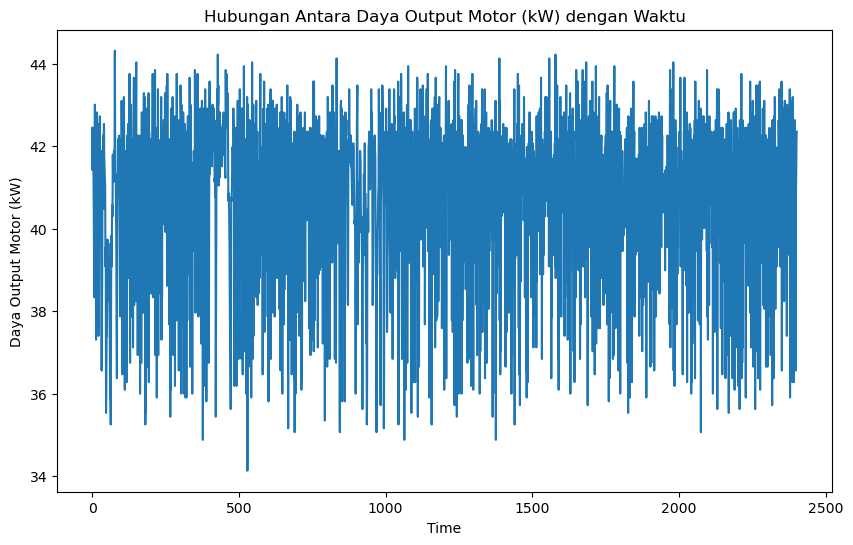

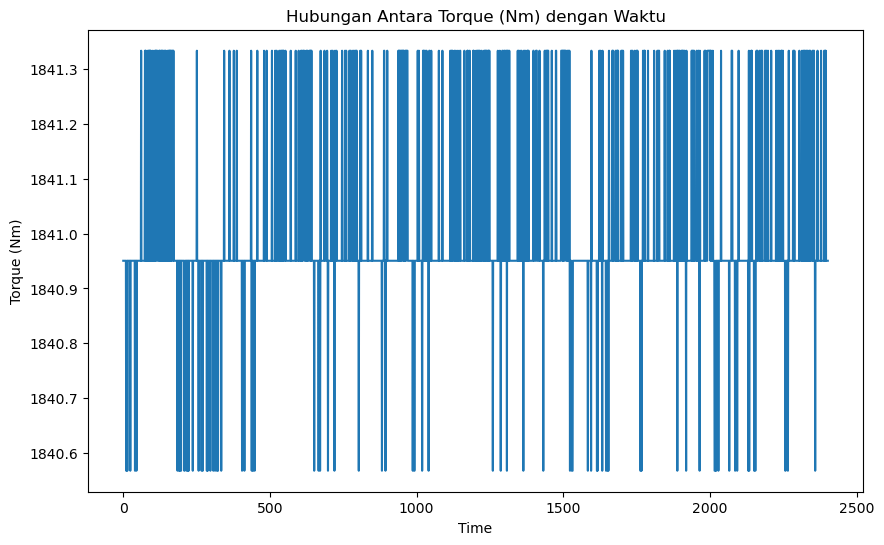

In [96]:
# Hubungan Antara Waktu dengan Variable Lain
for col in train.columns:
    if col != "Time":
        plt.figure(figsize=(10, 6))
        plt.plot(train.index, train[col], label=col)
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.title(f"Hubungan Antara {col} dengan Waktu")
        plt.show()

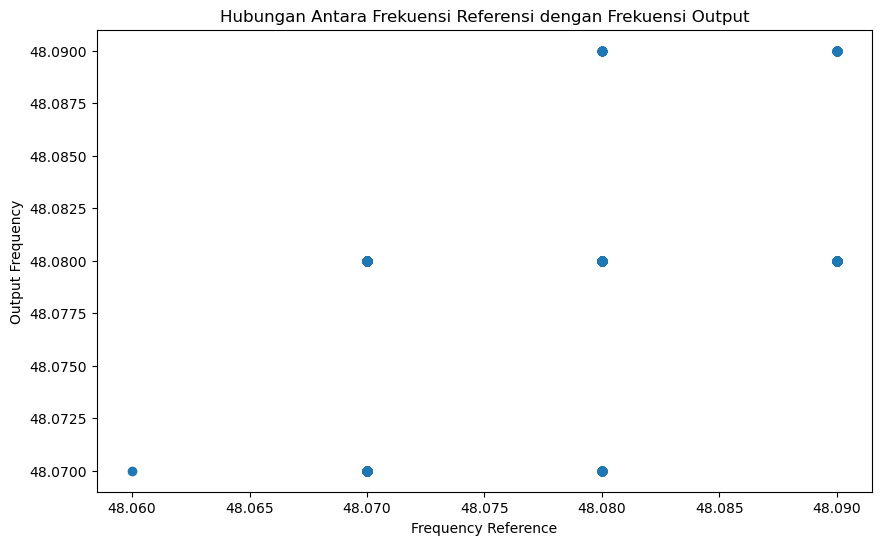

In [98]:
# Hubungan Antara Output Frekuensi dengan Frekuensi Referensi
plt.figure(figsize=(10, 6))
plt.scatter(df["Frequency Reference"], df["Output Frequency"])
plt.xlabel("Frequency Reference")
plt.ylabel("Output Frequency")
plt.title("Hubungan Antara Frekuensi Referensi dengan Frekuensi Output")
plt.show()

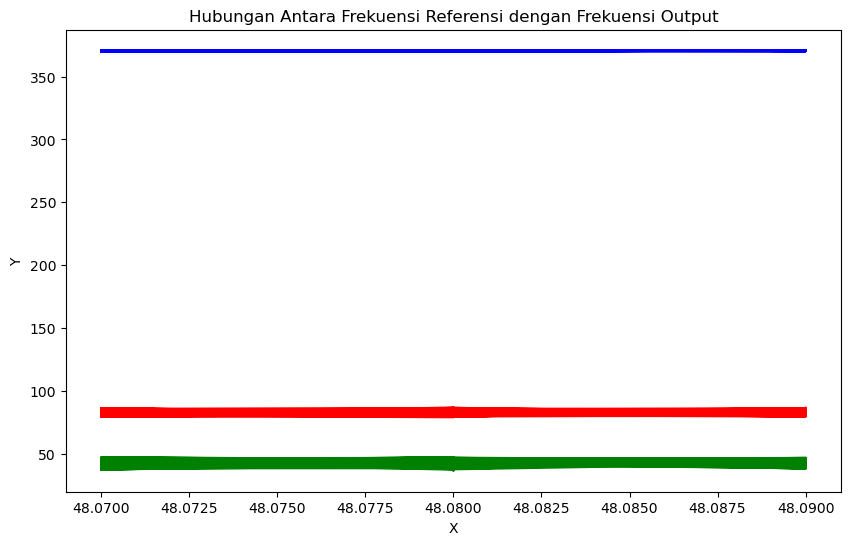

In [110]:
# Hubungan Antara beberapa variable dengan Output Frekuensi
plt.figure(figsize=(10, 6))
plt.plot(df["Output Frequency"], df["Output Power"], label="Output Power", color='g')
plt.plot(df["Output Frequency"], df["Output Voltage"], label="Output Voltage", color='b')
plt.plot(df["Output Frequency"], df["Output Current"], label="Output Current", color='r')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Hubungan Antara Frekuensi Referensi dengan Frekuensi Output")
plt.show()

### 3. Model Selection

In [128]:
# Ambil variable
x = train[['Frequency Reference', 'Output Current', 'Output Power', 'Output Voltage', 'Fin Temperature', 'Cooling Fin Temperature']].values
y = train[['Output Frequency']].values

# Normalisasi data
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Split train-test (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [129]:
# Model ANN dengan 3 hidden layer
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output 1 nilai (Frekuensi Output)
])

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Tampilkan Arsitektur Model
model.summary()


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2263.4241 - mae: 47.5695 - val_loss: 1913.1581 - val_mae: 43.7183
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1545.0741 - mae: 38.6684 - val_loss: 208.4960 - val_mae: 12.3870
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177.7953 - mae: 10.9417 - val_loss: 74.2202 - val_mae: 6.8538
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.0896 - mae: 7.5077 - val_loss: 47.0709 - val_mae: 5.3730
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.6520 - mae: 6.6680 - val_loss: 33.1974 - val_mae: 4.4883
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.0786 - mae: 5.7064 - val_loss: 24.4311 - val_mae: 3.8600
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.7493 - mae: 5.2499 - val_loss: 19.0046 - val_mae: 3.4076
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.2567 - mae: 4.9404 - val_loss: 14.1953 - val_mae: 2.9414
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━

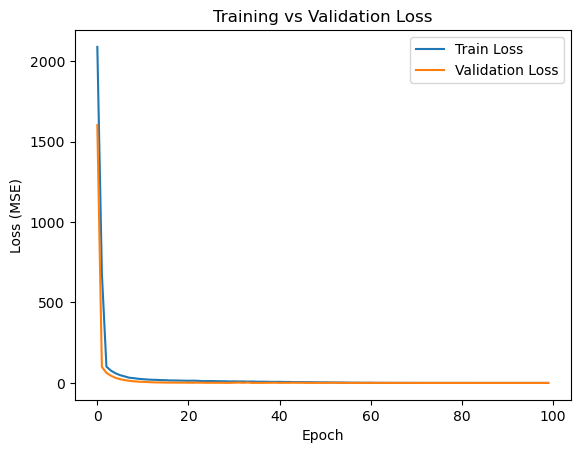

In [121]:
# Plot loss function
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


### 4. Evaluation and Testing

In [131]:
x_current = pd.read_csv('yaskawa3_test.csv')
x_current['Time'] = pd.to_timedelta(x_current['Time']).dt.total_seconds()

x_current.head(15)


,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh)
0,0.188,48.08,48.08,82.54,42.4,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
1,0.336,48.08,48.08,82.71,38.1,370.3,0.0,0.0,1.0,0.0,48.07,0.0,0.0,34.0,35.0,1388.0,627.0
2,0.487,48.09,48.08,83.20,42.5,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
3,0.632,48.08,48.08,83.33,44.4,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
4,0.775,48.07,48.08,85.93,47.5,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
5,0.918,48.09,48.08,84.43,45.5,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
6,1.058,48.08,48.08,80.03,44.8,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
7,1.183,48.09,48.09,81.61,42.9,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
8,1.333,48.09,48.08,82.05,38.6,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
9,1.474,48.07,48.07,82.32,44.1,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0


In [132]:
# Test 10 data
features = ['Frequency Reference', 'Output Current', 'Output Power', 'Output Voltage', 'Fin Temperature', 'Cooling Fin Temperature']
x_current[features] = scaler.transform(x_current[features])

x_current['Predicted Frequency'] = np.nan
x_current.loc[:9, 'Predicted Frequency'] = x_current.head(100).apply(
    lambda row: model.predict(np.array([row[features]]))[0][0], axis=1
)

x_current['error (%)'] = abs(x_current['Output Frequency'] - x_current['Predicted Frequency'])*100/x_current['Output Frequency']
x_current.head(15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh),Predicted Frequency,error (%)
0,0.188,0.195298,48.08,-0.045256,-0.567329,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.195847,0.240945
1,0.336,0.195298,48.08,0.042982,-2.584864,-1.474629,0.0,0.0,1.0,0.0,48.07,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.206100,0.262272
2,0.487,2.158897,48.08,0.297314,-0.520409,0.961627,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.194141,0.237399
3,0.632,0.195298,48.08,0.364790,0.371060,0.961627,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.199486,0.248515
4,0.775,-1.768302,48.08,1.714309,1.825562,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.230751,0.313542
5,0.918,2.158897,48.08,0.935741,0.887174,0.961627,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.194584,0.238319
6,1.058,0.195298,48.08,-1.348061,0.558738,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.210876,0.272206
7,1.183,2.158897,48.09,-0.527969,-0.332732,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.196289,0.221021
8,1.333,2.158897,48.08,-0.299589,-2.350267,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.208344,0.266937
9,1.474,-1.768302,48.07,-0.159446,0.230302,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.205006,0.280852


In [127]:
x_current.tail(15)

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh),Predicted Frequency,error (%)
1244,634.742,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1245,634.927,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1246,635.115,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1247,635.319,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1248,635.508,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1249,635.711,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1250,636.069,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1251,636.414,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1252,636.774,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1253,637.132,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
